# Document representation

This notebook evaluates methods for document representation using the [academia.stackexchange.com](https://academia.stackexchange.com/) data dump.

## Table of Contents
* [Data import](#data_import)
* [Document representation methods](#methods)
* [Fitting the document representation methods](#fitting)
* [Evaluation](#evaluation)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
from academia_tag_recommender.definitions import MODELS_PATH

<a id='data_import'/>

## Data Import

Since we don´t need all of the questions attributes from the raw data dump, we import a cleaner version.

In [2]:
from academia_tag_recommender.documents import documents

**Example:**

We show an example document for demonstration purposes:

In [3]:
print(documents[0].__dict__)

{'title': 'What kind of Visa is required to work in Academia in Japan?', 'body': '<p>As from title. What kind of visa class do I have to apply for, in order to work as an academic in Japan ? </p>\n', 'text': 'What kind of Visa is required to work in Academia in Japan?<p>As from title. What kind of visa class do I have to apply for, in order to work as an academic in Japan ? </p>\n', 'tags': ['job-search', 'visa', 'japan']}


Which results in having the following attribute keys for documents:

In [4]:
print(documents[0].__dict__.keys())

dict_keys(['title', 'body', 'text', 'tags'])


Where the `tags` have already been separated into strings and the `text` is a concatenated version of `title` and `body`.

<a id='methods'/>

## Document representation methods

To classify documents we need to choose an appropriate method to represent the documents.

This task is usually divided into text preprocessing and text transformation.

**Text Preprocessing**

Text Preprocessing defines which characters of the documents text will be part of the document representation. That decision is split into the following questions:

* **Preprocessing**

    In a preprocessing step we can remove parts of the text, that should not be part of the document representation (e.g. html tags, numbers, punctuation).

* **Tokenization**:

    In the tokenization step the text gets split into a vector of tokens. We define where to split the text (e.g. spaces, punctuation) and how to decide if a part of the text should appear in the vector (e.g. minimum length). Furthermore we can decide if unigrams (one word), bigrams (phrases consisting of two words) or even trigrams (phrases consisting of three words) should be tokens (called 'ngrams').
    
    Another decision has to made regarding how to differentiate between tokens. It might be not relevant whether text includes *student* or *students*, so it might be a could option to choose the same representation for both of them. This step is called *Normalization*. There are different normalization algorithms that either stem words to their word stem (e.g. Porter Stemmer, Lancaster Stemmer) or choose a generell represation for words describing the same topic (Lemmatizer).

* **Stop word removal**

    In natural speech there are words that appear often regardless of the meaning of the text. For text classification those might not be relevant (e.g. articles, pronouns). We can choose to remove them from the document representation.


**Text Transformation**

If we have the set of tokens we need to decide how to represent these features numerically for each of the documents.

* **Count** 
    
    The *count* describes how often the token appears in the document (absolute).
    
* **Term-frequency times inverse document-frequency (tfidf)**: 
    
    Where *term-frequency* describes how often the token appears in the document (normalized) and *document-frequency* describes the overall occurence of a term in the corpus.
    
    
**NLTK**

The [Natural Language Toolkit](https://www.nltk.org/) is a package to help with natural language tasks. For example it provides implementations of the stemming and lemmatization algorithms. We will use the function [`word_tokenize`](https://www.nltk.org/api/nltk.tokenize.html?highlight=word_tokenize#nltk.tokenize.word_tokenize) and the classes [`WordNetLemmatizer`](https://www.nltk.org/api/nltk.stem.html?highlight=lemmatizer#nltk.stem.wordnet.WordNetLemmatizer), [`EnglishStemmer`](https://www.nltk.org/api/nltk.stem.html?highlight=englishstemmer#nltk.stem.snowball.EnglishStemmer), [`PorterStemmer`](https://www.nltk.org/api/nltk.stem.html?highlight=porter%20stemmer#nltk.stem.porter.PorterStemmer), [`LancasterStemmer`](https://www.nltk.org/api/nltk.stem.html?highlight=lancasterstemmer#nltk.stem.lancaster.LancasterStemmer).

**scikit-learn**

[scikit-learn](https://scikit-learn.org/stable/) is a python package designed for machine learning tasks. We will use this package for the document representation.

The text transformation task is called *[Feature extraction](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction)* in scikit-learn. We will use the class [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) and [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer) to test the two methods discussed above.

### Parameters for testing

The above described methods result in the following parameters for the decision which document representation to use. In the case of ` Preprocessor` and `Tokenizer` the value `None` means that we use `scikit-learn`s standard implementation.

* Vectorizer `CountVectorizer`, `TfidfVectorizer`
* Preprocessor `None`, `BasicPreprocessor` 
* Tokenizer
    * without normalization: `None`, `BasicTokenizer`
    * with normalization:
        * Stemmer: `EnglishStemmer`, `PorterStemmer`, `LancasterStemmer`
        * Lemmatizer: `Lemmatizer`
* Stopwords `None`, `'english'`
* NGrams `(1, 1)`, `(1, 2)`, `(1, 3)`, `(2, 2)`, `(2, 3)`, `(3, 3)`

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from academia_tag_recommender.preprocessor import BasicPreprocessor
from academia_tag_recommender.tokenizer import BasicTokenizer, EnglishStemmer, PorterStemmer, LancasterStemmer, Lemmatizer
from academia_tag_recommender.vectorizer_computation import get_vect_feat_with_params

The function `get_vect_feat_with_params` returns the vectorizer and the features that result in fitting a model with the given parameters. It only fits the model if it has not been fitted before, since those models get stored in a file.

In [6]:
vectorizers = [CountVectorizer, TfidfVectorizer]
preprocessors = [None, BasicPreprocessor]
tokenizers = [None, BasicTokenizer, EnglishStemmer, PorterStemmer, LancasterStemmer, Lemmatizer]
stop_word_options = [None, 'yes']
n_gram_options = [(1,1), (1,2), (2,2), (1,3), (2,3), (3,3)]

<a id='fitting'/>

## Fitting the document representation models

As data input we only need the texts of the documents.

In [7]:
texts = [document.text for document in documents]

The following function trains models for all the given paramters. Those are stored and can be accessed individually.

In [8]:
def create_models_with_paramters(vectorizers, preprocessors, tokenizers, stop_word_options, n_gram_options):
    for v in vectorizers:
        for p in preprocessors:
            for t in tokenizers:
                for s in stop_word_options:
                    for n in n_gram_options:
                        get_vect_feat_with_params(texts, v, t, p, s, n, True)

In [9]:
# create_models_with_paramters(vectorizers, preprocessors, tokenizers, stop_word_options, n_gram_options)

<a id='evaluation'/>

## Evaluation

While fitting the document representation models we save some computation results (e.g. processing time) to compare the methods afterwards.

This is just a basic evaluation regarding performance and feature vector size. The *best* document representation model can only be determined after classification.

In [10]:
results = load(MODELS_PATH + '/document_representation/results.joblib')

We can access models with a specific *n_grams* option.

In [11]:
unigrams = [result for result in results if result['n_grams'] == '(1, 1)']
bigrams = [result for result in results if result['n_grams'] == '(2, 2)']
trigrams = [result for result in results if result['n_grams'] == '(3, 3)']

**Shape and Processing Time**

We examine the shape and processing time of the feature vectors depending on the *Tokenizer*, the *Preprocessor* and if a *stopwordlist* is used..

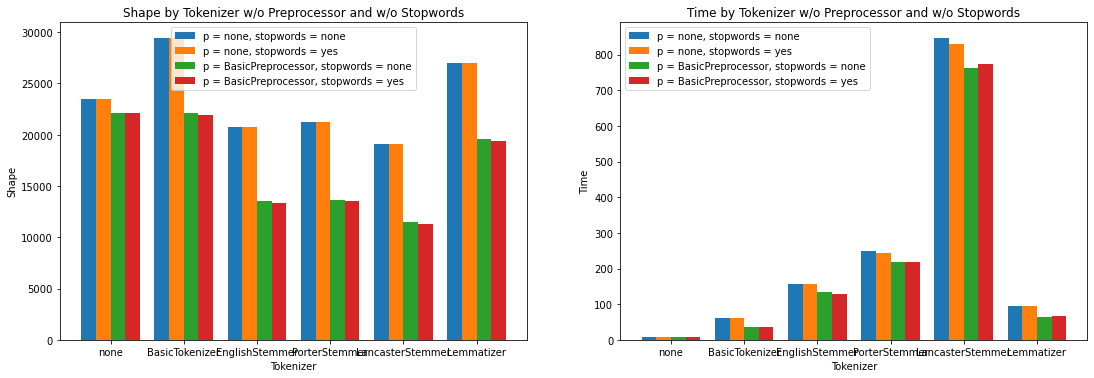

In [12]:
labels = ['none', 'BasicTokenizer', 'EnglishStemmer', 'PorterStemmer', 'LancasterStemmer', 'Lemmatizer']
count_vect_unigrams = [unigram for unigram in unigrams if unigram['v'] == 'CountVectorizer']
count_vect_unigrams.sort(key = lambda unigram: labels.index(unigram['t']))

def feat_with_values(feature, p, s):
    arr = [unigram[feature] for unigram in count_vect_unigrams if unigram['stopwords'] == s and unigram['p'] == p]
    if isinstance(arr[0], tuple):
        arr = [feat[1] for feat in arr]
    return arr
                 
x = np.arange(len(labels))
bar_width = 0.20

fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)

def bar_with_feat(feature, ax):
    ax.bar(x - bar_width/2*3, feat_with_values(feature, 'none', 'none'), bar_width, label='p = none, stopwords = none')
    ax.bar(x - bar_width/2, feat_with_values(feature, 'none', 'yes'), bar_width, label='p = none, stopwords = yes')
    ax.bar(x + bar_width/2, feat_with_values(feature, 'BasicPreprocessor', 'none'), bar_width, label='p = BasicPreprocessor, stopwords = none')
    ax.bar(x + bar_width/2*3, feat_with_values(feature, 'BasicPreprocessor', 'yes'), bar_width, label='p = BasicPreprocessor, stopwords = yes')
    ax.set_ylabel('{}'.format(feature.capitalize()))
    ax.set_title('{} by Tokenizer w/o Preprocessor and w/o Stopwords'.format(feature.capitalize()))
    ax.set_xticks(x)
    ax.set_xlabel('Tokenizer')
    ax.set_xticklabels(labels)
    ax.legend()
    
bar_with_feat('shape', axes[0])
bar_with_feat('time', axes[1])

plt.show()

Looking at the graphs we see that the usage of a *stopwordlist* does have an insignificant effect on the shape of the feature vector, while it increases the processing time slightly.

The *preprocessor* used by the nltk implementation does lead to more features while usually having a longer processing time than the BasicPreprocessor.

We see a big difference in the processing time of the *tokenizers*, where no tokenizer is obviously the fastest. While the `EnglishStemmer` and the `PorterStemmer`seem to lead to the same amount of features, the `PorterStemmer` does need much more time compute. 

The `LancasterStemmer` takes by far the longest processing time.

**TfidfVectorizer**

To explore the effect of the inverse document frequency of the `TfidfVectorizer` we compare the numerical values of the features.

Received saved model
Received saved model
Received saved model
Received saved model
Received saved model
Received saved model


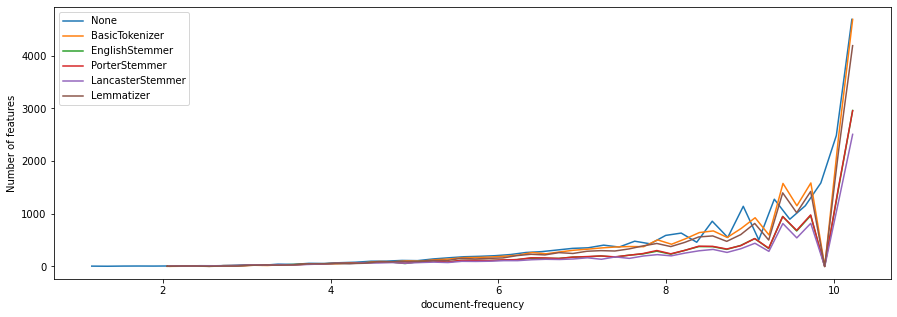

In [13]:
v = TfidfVectorizer
p = BasicPreprocessor
ts = [None, BasicTokenizer, EnglishStemmer, PorterStemmer, LancasterStemmer, Lemmatizer]
stopwords = 'yes'
ngrams = '(1, 1)'

fig, ax = plt.subplots(figsize=(15,5))

histograms = []
for tokenizer in ts:
    [vectorizer, features] = get_vect_feat_with_params(texts, v, tokenizer, p, stopwords, ngrams, False)

    y, binEdges = np.histogram(vectorizer.idf_, bins=50)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax.plot(bincenters, y)

ax.set_xlabel('document-frequency')
ax.set_ylabel('Number of features')
ax.legend([t.__name__ if t else 'None' for t in ts])

plt.show()

Plotting the histogram data for 50 bins reveals that the document-frequency is higher than 6 for the majority of the words. Using the `TfidfVectorizer` with the inverse document-frequencies will lead to many features with values close to zero. And therefore helps focussing on the features that are descriptive for the document.

**Count vs. Tfidf**

To see the above stated effect clearlier we investigate the feature values of the document representation models.

We first define the value ranges we want to inspect.

In [14]:
ranges = [(1, 1), (2, 10), (11, 100), (101, 1000), (1001, 10000), (10001, 100000), (1001, 2000), (2001, 3000), (3001, 4000), (4001, 5000), (5001, 6000), (6001, 7000), (7001, 8000), (8001, 9000), (9001, 10000), (10001, 100000)]

Afterwards we define some functions that help us examine the features for a given model.

In [15]:
def get_number_of_values_in_range(data: list, range_: tuple) -> int:
    return len([value for _, value in data if value >= range_[0] and value <= range_[1]])

def get_statistics_for(data: list) -> dict:
    stats = {}
    stats['features'] = len(data)
    stats['min'] = data[-1][1]
    stats['max'] = data[0][1]
    for range_ in ranges:
        stats['[{}-{}]'.format(*range_)] = get_number_of_values_in_range(data, range_)
    return stats

def get_summed_values(vocabulary, features):
    sum_words = features.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vocabulary]
    return list(sorted(words_freq, key = lambda x: x[1], reverse=True))

def analyze(v, p, t, stopwords, ngrams): 
    [vectorizer, features] = get_vect_feat_with_params(texts, v, t, p, stopwords, ngrams, False)
    summed_values = get_summed_values(vectorizer.vocabulary_.items(), features)
    return get_statistics_for(summed_values)

In [16]:
ts = [None, BasicTokenizer, EnglishStemmer, PorterStemmer, LancasterStemmer, Lemmatizer]

stats = {'CountVectorizer': {}, 'TfidfVectorizer': {}}
for tokenizer in ts:
    stats['CountVectorizer'][tokenizer.__name__ if tokenizer else 'None'] = analyze(CountVectorizer, BasicPreprocessor, tokenizer, 'yes', (1, 1))
    stats['TfidfVectorizer'][tokenizer.__name__ if tokenizer else 'None'] = analyze(TfidfVectorizer, BasicPreprocessor, tokenizer, 'yes', (1, 1))

Received saved model
Received saved model
Received saved model
Received saved model
Received saved model
Received saved model
Received saved model
Received saved model
Received saved model
Received saved model
Received saved model
Received saved model


In [17]:
def print_stats_for(vectorizer: str):
    print('\nStats for {}'.format(vectorizer))
    print_string = '{:<15}' + ''.join(['{:<15}' for t in ts])
    p
    print(print_string.format(*(['Range']+print_title)))
    print(print_string.format(*(['Features']+[stats[vectorizer][t]['features'] for t in print_title])))
    for range_ in ranges:
        key = '[{}-{}]'.format(*range_)
        print(print_string.format(*([key]+[stats[vectorizer][t][key] for t in print_title])))

In [18]:
print_stats_for('CountVectorizer')
print_stats_for('TfidfVectorizer')


Stats for CountVectorizer
Range          None           BasicTokenizer EnglishStemmer PorterStemmer  LancasterStemmerLemmatizer     


NameError: name 'print_title' is not defined

For the defined ranges we print how many features have summed counts inside the range.

Whe comparing the `CountVectorizer` to the `TfidfVectorizer` we see again, that it prevents the values from getting too big resulting in more feature values that are small. When fitting the categorizer models we might benefit from smaller values computationwise.